## Import libraries

In [1]:
from pyomo.environ import (Constraint,
                           Var,
                           ConcreteModel,
                           Expression,
                           Param,
                           Objective,
                           SolverFactory,
                           TransformationFactory,
                           value)

from pyomo.network import Arc, SequentialDecomposition

from idaes.core.util.initialization import propagate_state

# Import plotting functions
import matplotlib.pyplot as plt

# Import numpy library 
import numpy as np

# Import the main FlowsheetBlock from IDAES. The flowsheet block will contain the unit model
from idaes.core import FlowsheetBlock

import idaes.logger as idaeslog
from pyomo.opt import TerminationCondition, SolverStatus

# Import the degrees_of_freedom function from the idaes.core.util.model_statistics package
# DOF = Number of Model Variables - Number of Model Constraints
from idaes.core.util.model_statistics import degrees_of_freedom

# Import the Generic Parameter Block
from idaes.generic_models.properties.core.generic.generic_property import (
        GenericParameterBlock)

# Import unit models from the model library
from idaes.generic_models.unit_models import Flash

# Import R32, R125, IL info file
from HFCS_emimTF2N_PR import configuration

## Create Model

In [2]:
# Create the ConcreteModel and the FlowsheetBlock, and attach the flowsheet block to it.
m = ConcreteModel()

m.fs = FlowsheetBlock(default={"dynamic": False}) 

# Add properties parameter blocks to the flowsheet with specifications
m.fs.props = GenericParameterBlock(default=configuration)

In [3]:
m.fs.F101 = Flash(default={"property_package": m.fs.props,
                               "has_heat_transfer": True,
                               "has_pressure_change": True})

# Call the degrees_of_freedom function, get intitial DOF
DOF_initial = degrees_of_freedom(m)
print("The initial DOF is {0}".format(DOF_initial))

The initial DOF is 8


In [4]:
## Update conditions to reduce DOF

# Fix Heater H101 inlet conditions
m.fs.F101.inlet.mole_frac_comp[0, "R32"].fix(0.5)
m.fs.F101.inlet.mole_frac_comp[0, "R125"].fix(0.5)
m.fs.F101.inlet.mole_frac_comp[0, "emimTf2N"].fix(0.001)

m.fs.F101.inlet.flow_mol[0].fix(1)
m.fs.F101.inlet.temperature.fix(300)
m.fs.F101.inlet.pressure.fix(200000)

# Fix F101 Flash outlet conditions
m.fs.F101.vap_outlet.temperature.fix(300)
m.fs.F101.deltaP.fix(0)

DOF_final = degrees_of_freedom(m)
print("The final DOF is {0}".format(DOF_final))

The final DOF is 0


In [5]:
solver = SolverFactory('ipopt')
solver.options = {'tol': 1e-6}

## Calculate flash data

In [6]:
# Set pressures to loop over
P = [200000,300000,400000,500000,600000,700000,800000,900000,1000000,1100000,1200000,1300000,1400000,1500000,1600000]

# Set fraction of feed compositions of HFCs to loop over
HFC_feed_frac = [0.001,0.2,0.4,0.72,0.91,0.99]

# Make outlet arrays
IL_x = np.zeros((len(P),len(HFC_feed_frac)))
IL_y = np.zeros((len(P),len(HFC_feed_frac)))
R32_x = np.zeros((len(P),len(HFC_feed_frac)))
R32_y = np.zeros((len(P),len(HFC_feed_frac)))
R125_x = np.zeros((len(P),len(HFC_feed_frac)))
R125_y = np.zeros((len(P),len(HFC_feed_frac))) 

for i in range(len(P)):
    
    # Fix pressure
    m.fs.F101.inlet.pressure.fix(P[i])
    
    for j in range(len(HFC_feed_frac)):
        
        # Fix inlet mole fractions
        fract = 1 - HFC_feed_frac[j] 
        m.fs.F101.inlet.mole_frac_comp[0, "R32"].fix(0.85*HFC_feed_frac[j])
        m.fs.F101.inlet.mole_frac_comp[0, "R125"].fix(0.85*fract)
        m.fs.F101.inlet.mole_frac_comp[0, "emimTf2N"].fix(0.15)   

        m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)              

        # solve the model
        status = solver.solve(m, tee = False)
        # model.display()
        
        # If solution is optimal store the concentration, and calculated temperatures in the created arrays
        if (status.solver.status == SolverStatus.ok) and (status.solver.termination_condition == TerminationCondition.optimal):

            IL_x[i,j] = value(m.fs.F101.liq_outlet.mole_frac_comp[0, "emimTf2N"])
            IL_y[i,j] = value(m.fs.F101.vap_outlet.mole_frac_comp[0, "emimTf2N"])
            R32_x[i,j] = value(m.fs.F101.liq_outlet.mole_frac_comp[0, "R32"]) 
            R32_y[i,j] = value(m.fs.F101.vap_outlet.mole_frac_comp[0, "R32"])
            R125_x[i,j] = value(m.fs.F101.liq_outlet.mole_frac_comp[0, "R125"])
            R125_y[i,j] = value(m.fs.F101.vap_outlet.mole_frac_comp[0, "R125"])

            #Change this to feasible
            print("Running pressure:",P[i],"and HFC feed fraction",HFC_feed_frac[j])
#             print(value(m.fs.F101.liq_outlet.flow_mol[0]))
#             print(value(m.fs.F101.vap_outlet.flow_mol[0]))
        else:
            print('Infeasible.')

    

Running pressure: 200000 and HFC feed fraction 0.001
Running pressure: 200000 and HFC feed fraction 0.2
Running pressure: 200000 and HFC feed fraction 0.4
Running pressure: 200000 and HFC feed fraction 0.72
Running pressure: 200000 and HFC feed fraction 0.91
Running pressure: 200000 and HFC feed fraction 0.99
Running pressure: 300000 and HFC feed fraction 0.001
Running pressure: 300000 and HFC feed fraction 0.2
Running pressure: 300000 and HFC feed fraction 0.4
Running pressure: 300000 and HFC feed fraction 0.72
Running pressure: 300000 and HFC feed fraction 0.91
Running pressure: 300000 and HFC feed fraction 0.99
Running pressure: 400000 and HFC feed fraction 0.001
Running pressure: 400000 and HFC feed fraction 0.2
Running pressure: 400000 and HFC feed fraction 0.4
Running pressure: 400000 and HFC feed fraction 0.72
Running pressure: 400000 and HFC feed fraction 0.91
Running pressure: 400000 and HFC feed fraction 0.99
Running pressure: 500000 and HFC feed fraction 0.001
Running pressu

In [7]:
print("IL_x =", IL_x)
print("IL_y =", IL_y)
print("R32_x =", R32_x)
print("R32_y =", R32_y)
print("R125_x =", R125_x)
print("R125_y =", R125_y)

IL_x = [[0.8983654  0.88293381 0.86749323 0.84293077 0.82842905 0.82234119]
 [0.84850668 0.82752619 0.80655759 0.77326013 0.75363856 0.74540993]
 [0.7991385  0.77402027 0.7489067  0.70902866 0.685537   0.67568738]
 [0.75012174 0.7222592  0.69432135 0.64983873 0.62357913 0.61255697]
 [0.70128416 0.67206465 0.64256351 0.59527117 0.56719656 0.55537858]
 [0.65240522 0.62322968 0.59337524 0.54489611 0.5158184  0.50351408]
 [0.60319096 0.57550709 0.54647542 0.49828132 0.46888704 0.45634625]
 [0.55322953 0.52858982 0.50155257 0.45499696 0.42586812 0.41329054]
 [0.50190644 0.48207574 0.45825088 0.4146161  0.38625487 0.37380003]
 [0.44822267 0.43539978 0.4161434  0.37670968 0.34956663 0.33736428]
 [0.3903356  0.38768806 0.3746786  0.34083331 0.31534151 0.3035021 ]
 [0.32403361 0.33738986 0.33306425 0.30650021 0.28312104 0.2717477 ]
 [0.23330632 0.2810643  0.28997422 0.27312548 0.25242179 0.24162607]
 [0.         0.20612212 0.24258887 0.2398985  0.22267887 0.21260735]
 [0.         0.         0.1

In [8]:
IL_x = IL_x*100
IL_y = IL_y*100
R32_x = R32_x*100
R32_y = R32_y*100
R125_x = R125_x*100
R125_y = R125_y*100

In [9]:
points_x = []

for i in range(len(P)):
    for j in range(len(HFC_feed_frac)): #to shift how points are printed, shift the order
        points = (IL_x[i,j], R125_x[i,j], R32_x[i,j])
        points_x.append(points)

points 1 are: [(89.83653950336131, 10.14492106786532, 0.018539428773381373), (88.29338133056875, 8.027251445255166, 3.679367224176089), (86.7493232683821, 5.948546852068055, 7.30212987954985), (84.29307708028186, 2.7233535105725686, 12.983569409145582), (82.84290544699878, 0.8655129418629297, 16.291581611134273), (82.23411902973362, 0.0957120066390074, 17.670168963627354)]
points 2 are: [(84.85066842752546, 15.12227006369377, 0.02706150878077031), (82.75261903837053, 11.896891554153456, 5.3504894074760365), (80.65575916746758, 8.765508866885023, 10.5787319656474), (77.32601250969421, 3.9765544053589044, 18.697433084946873), (75.36385562753244, 1.2570449084455424, 23.37909946402201), (74.54099251812522, 0.13869771033482864, 25.32030977153994)]
points 3 are: [(79.91385010011102, 20.051066619551356, 0.03508328033760227), (77.40202687988362, 15.686616942011883, 6.911356178104508), (74.89067025193988, 11.493967024945563, 13.61536272311454), (70.90286610096427, 5.169446067429109, 23.92768783

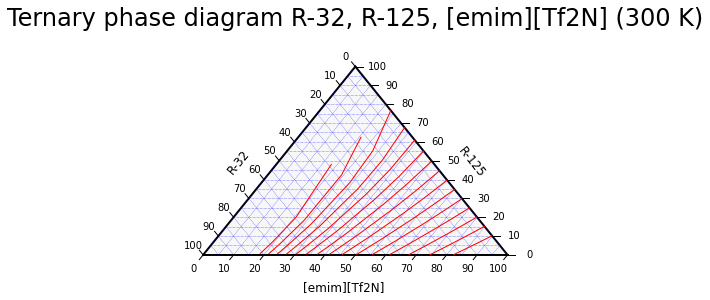

In [12]:
import ternary

scale = 100
figure, tax = ternary.figure(scale=scale)

# Draw Boundary and Gridlines
tax.boundary(linewidth=2.0)
tax.gridlines(color="blue", multiple=5)

# Set Axis labels and Title
fontsize = 12
offset = 0.14
tax.set_title("Ternary phase diagram R-32, R-125, [emim][Tf2N] (300 K)\n", fontsize=24)
tax.left_axis_label("R-32", fontsize=fontsize, offset=offset)
tax.right_axis_label("R-125", fontsize=fontsize, offset=offset)
tax.bottom_axis_label("[emim][Tf2N]", fontsize=fontsize, offset=offset)

# color_options = ['red','blue','green','black','orange','purple','teal','yellow','pink']

for i in range(len(P)):
#     color = color_options[i]
    if P[i]<=1400000:
        i = i + 1
        print("points",i,"are:",points_x[6*i-6:6*i])
        tax.plot(points_x[6*i-6:6*i], linewidth=1., color='red', linestyle="-")
    elif P[i]==1500000:
        i = i + 1
        print("points",i,"are:",points_x[6*i-6:6*i])
        tax.plot(points_x[6*i-5:6*i], linewidth=1., color='red', linestyle="-")
    else:
        i = i + 1
        print("points",i,"are:",points_x[6*i-6:6*i])
        tax.plot(points_x[6*i-4:6*i], linewidth=1., color='red', linestyle="-")

tax.ticks(axis='lbr', multiple=10, linewidth=1, offset=0.025)
tax.get_axes().axis('off')
tax.clear_matplotlib_ticks()
tax.show()
tax.savefig('emimTf2N_ternary_300K_Psweep.pdf')